In [ ]:
import tensorflow as tf
print(tf.__version__)

2024-04-29 04:48:47.522663: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 04:48:47.572504: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 04:48:49.965042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2024-04-29 04:49:08.017711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 04:49:08.021284: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
import librosa
# Utility functions for loading audio files and making sure the sample rate is correct.
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    y, sr = librosa.load(filename, sr=16000, mono=True) # y = audio time series
    return y

In [5]:
files_csv = './dataset_metadata.csv'

pd_data = pd.read_csv(files_csv)
pd_data.head()

,filename,emotion,target
0,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
1,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
2,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
3,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
4,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0


In [6]:
#my_classes = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised']
my_classes = ['Neutra', 'Calma', 'Felicidade', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Nojo']

In [ ]:
filenames = pd_data['filename']
targets = pd_data['target']
emotions = pd_data['emotion']
dataset = []

for f in filenames:
    wav = np.array(load_wav_16k_mono(f))
    dataset.append(wav)

In [8]:
highest_audio_length = len(max(dataset, key=len))

# Padding audios shorter than the highest audio length with 0's to normalize and allow passing through models
for index, audio_file in enumerate(dataset):
    if len(audio_file) < highest_audio_length:
        dataset[index] = librosa.util.pad_center(audio_file, size=highest_audio_length, mode='constant')

In [ ]:
# Applies the embedding extraction model to a wav data
def extract_embedding(wav_data):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  return embeddings

# The embedding extraction returns a 1024-D tensor for each 0,96 sec of audio. Need to flatten the embeddings to pass through classifiers
# The embeddings tensor will be a Tensor with N positions (1 position for each 0,96 sec), where each position is the 1024-D tensor
# Generating an embedding to get its shape, and latter flatten (reshape) the tensors with the correct dimmensions
_, temp_embeddings,_ = yamnet_model(dataset[0])
embeddings_shape = temp_embeddings.shape
number_of_tensors = embeddings_shape[0]
embeddings_length = embeddings_shape[1]
flattened_dimmension = number_of_tensors * embeddings_length

# Extract embeddings
for index, wav_file in enumerate(dataset):
    embeddings = extract_embedding(wav_file)
    flattened_tensor = tf.reshape(embeddings, [flattened_dimmension])
    numpy_array = flattened_tensor.numpy()
    dataset[index] = numpy_array

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X = dataset.copy()
Y = targets.copy()
crossvalidation_scores =[]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svm', svm.SVC())])

In [13]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
scores = cross_val_score(pipe, X, Y, cv=kf)

y_pred = cross_val_predict(pipe, X, Y, cv=kf)

Fold 1: Score = 0.4757
Fold 2: Score = 0.4410
Fold 3: Score = 0.4306
Fold 4: Score = 0.4132
Fold 5: Score = 0.4722
Average Score: 0.4465 +- 0.0241
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.02      0.02      0.02       192
           2       0.11      0.09      0.10       192
           3       0.03      0.03      0.03       192
           4       0.19      0.17      0.18       192
           5       0.04      0.04      0.04       192
           6       0.18      0.19      0.19       192
           7       0.21      0.25      0.23       192

    accuracy                           0.11      1440
   macro avg       0.10      0.10      0.10      1440
weighted avg       0.10      0.11      0.10      1440



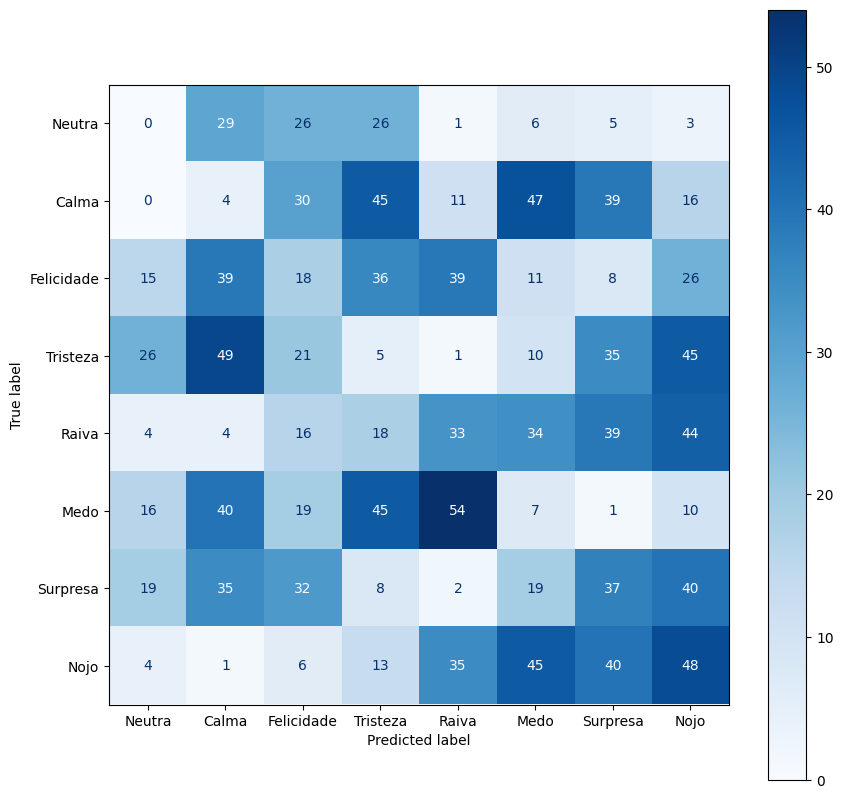

In [28]:
for fold_index, score in enumerate(scores):
    print(f"Fold {fold_index + 1}: Score = {score:.4f}")
print(f"Average Score: {np.mean(scores):.4f} +- {np.std(scores):.4f}")

print(metrics.classification_report(Y, y_pred))

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(Y, y_pred, cmap='Blues', display_labels=my_classes, ax=ax)

Fold 1: Score = 0.4792
Fold 2: Score = 0.4410
Fold 3: Score = 0.4722
Fold 4: Score = 0.4653
Fold 5: Score = 0.5347
Average Score: 0.4785 +- 0.0309
              precision    recall  f1-score   support

           0       0.44      0.35      0.39        96
           1       0.55      0.72      0.62       192
           2       0.34      0.23      0.28       192
           3       0.27      0.22      0.24       192
           4       0.50      0.54      0.52       192
           5       0.51      0.45      0.48       192
           6       0.44      0.47      0.46       192
           7       0.55      0.67      0.60       192

    accuracy                           0.47      1440
   macro avg       0.45      0.46      0.45      1440
weighted avg       0.45      0.47      0.45      1440



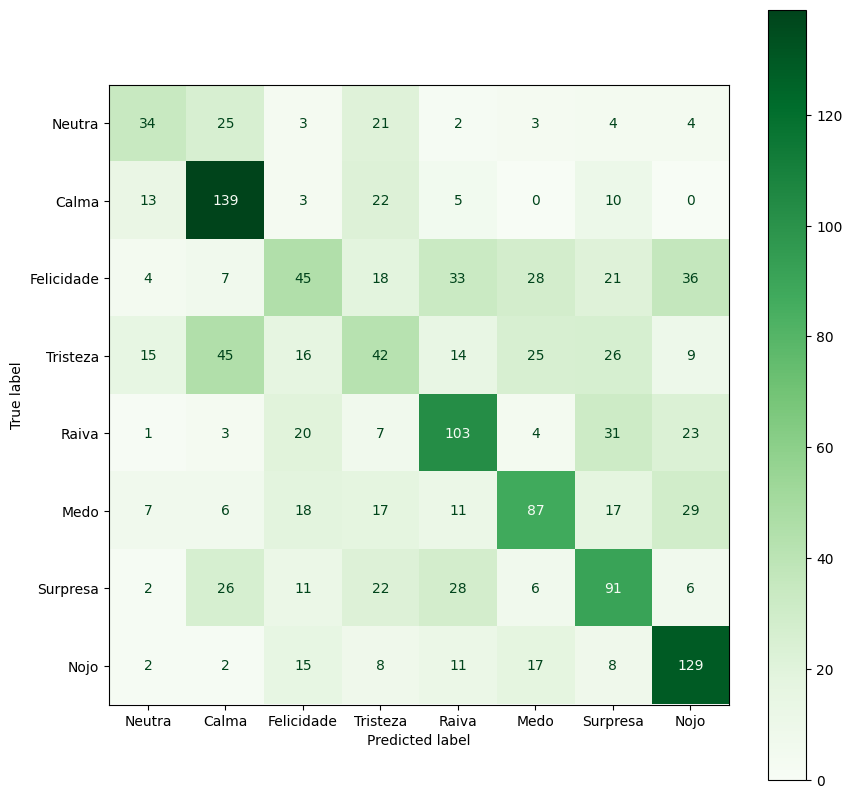

In [29]:
#SCIKIT Random Forest

from sklearn.ensemble import RandomForestClassifier

pipe_forest = Pipeline(steps=[('scaler', StandardScaler()), ('forest', RandomForestClassifier())])

scores_forest = cross_val_score(pipe_forest, X, Y, cv=kf)

y_pred_forest = cross_val_predict(pipe_forest, X, Y, cv=kf)

for fold_index, score in enumerate(scores_forest):
    print(f"Fold {fold_index + 1}: Score = {score:.4f}")
print(f"Average Score: {np.mean(scores_forest):.4f} +- {np.std(scores_forest):.4f}")

print(metrics.classification_report(Y, y_pred_forest))

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(Y, y_pred_forest, cmap='Greens', display_labels=my_classes, ax=ax)

Fold 1: Score = 0.2083
Fold 2: Score = 0.2222
Fold 3: Score = 0.1840
Fold 4: Score = 0.2292
Fold 5: Score = 0.2431
Average Score: 0.2174 +- 0.0201
              precision    recall  f1-score   support

           0       0.15      0.53      0.23        96
           1       0.34      0.07      0.11       192
           2       0.19      0.33      0.24       192
           3       0.08      0.01      0.02       192
           4       0.26      0.33      0.29       192
           5       0.28      0.10      0.15       192
           6       0.25      0.19      0.22       192
           7       0.27      0.33      0.30       192

    accuracy                           0.22      1440
   macro avg       0.23      0.24      0.19      1440
weighted avg       0.23      0.22      0.19      1440



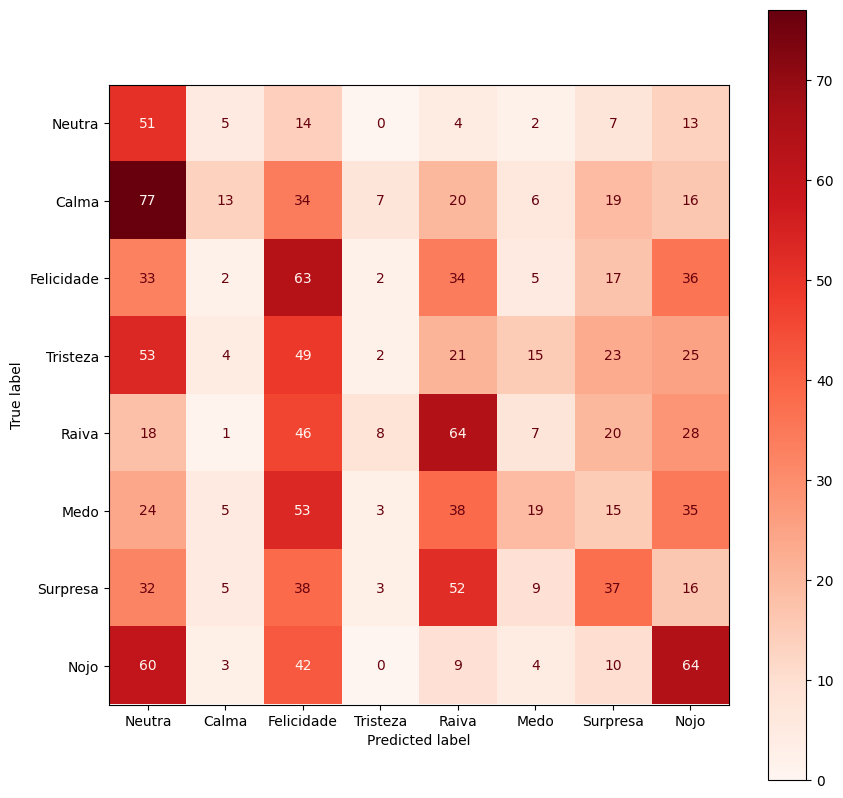

In [30]:
# SVM Naive Bayes
from sklearn.naive_bayes import GaussianNB

pipe_naive_bayes = Pipeline(steps=[('scaler', StandardScaler()), ('naive', GaussianNB() )])

scores_naive_bayes = cross_val_score(pipe_naive_bayes, X, Y, cv=kf)

y_pred_naive_bayes = cross_val_predict(GaussianNB(), X, Y, cv=kf)
y_pred_naive_bayes = cross_val_predict(pipe_naive_bayes, X, Y, cv=kf)

for fold_index, score in enumerate(scores_naive_bayes):
    print(f"Fold {fold_index + 1}: Score = {score:.4f}")
print(f"Average Score: {np.mean(scores_naive_bayes):.4f} +- {np.std(scores_naive_bayes):.4f}")

print(metrics.classification_report(Y, y_pred_naive_bayes))

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(Y, y_pred_naive_bayes, cmap='Reds', display_labels=my_classes, ax=ax)

In [22]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(number_of_tensors * 1024), dtype=tf.float32,
                          name='input_embedding_layer'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=5,
                                            restore_best_weights=True)

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               5243392   
                                                                 
 dense_9 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 5247496 (20.02 MB)
Trainable params: 5247496 (20.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
dataset_numpy = np.array(dataset)
targets_numpy = np.array(targets)

y_true = np.array([], np.int32)
y_pred = np.array([], np.int32)

fold_index = 1
scores_neural_network = np.array([])


for train_indexes, test_indexes in kf.split(dataset_numpy, targets_numpy):
    train_ds = np.array(dataset_numpy[train_indexes])
    train_labels = np.array(targets_numpy[train_indexes])
    
    test_ds = np.array(dataset_numpy[test_indexes])
    test_labels = np.array(targets_numpy[test_indexes])
    
    history = my_model.fit(x=train_ds, y=train_labels,
                       epochs=500,
                       callbacks=callback,
                       verbose=0)

    loss, accuracy = my_model.evaluate(test_ds, test_labels, verbose=0)
   
    print(f"Fold {fold_index }: Score = {accuracy:.4f}")  
    
    # Adding true labels and predicted labels to their respective arrays
    y_true = np.concatenate((y_true, test_labels))
    
    fold_predictions = my_model.predict(test_ds, verbose=0).argmax(axis=1)
    y_pred = np.concatenate((y_pred, fold_predictions))

    # Adding accuracy to array
    scores_neural_network = np.append(scores_neural_network, [accuracy])

    fold_index += 1
    print()


Fold 1: Score = 0.5694

Fold 2: Score = 0.7882

Fold 3: Score = 0.8924

Fold 4: Score = 0.8611

Fold 5: Score = 0.8924



In [24]:
print(f"\n\nAverage Score: {np.mean(scores_neural_network):.4f} +- {np.std(scores_neural_network):.4f}")
print(metrics.classification_report(y_true, y_pred))



Average Score: 0.8007 +- 0.1217
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        96
           1       0.86      0.88      0.87       192
           2       0.63      0.80      0.71       192
           3       0.74      0.69      0.72       192
           4       0.90      0.80      0.85       192
           5       0.90      0.78      0.83       192
           6       0.87      0.87      0.87       192
           7       0.78      0.80      0.79       192

    accuracy                           0.80      1440
   macro avg       0.81      0.80      0.80      1440
weighted avg       0.81      0.80      0.80      1440



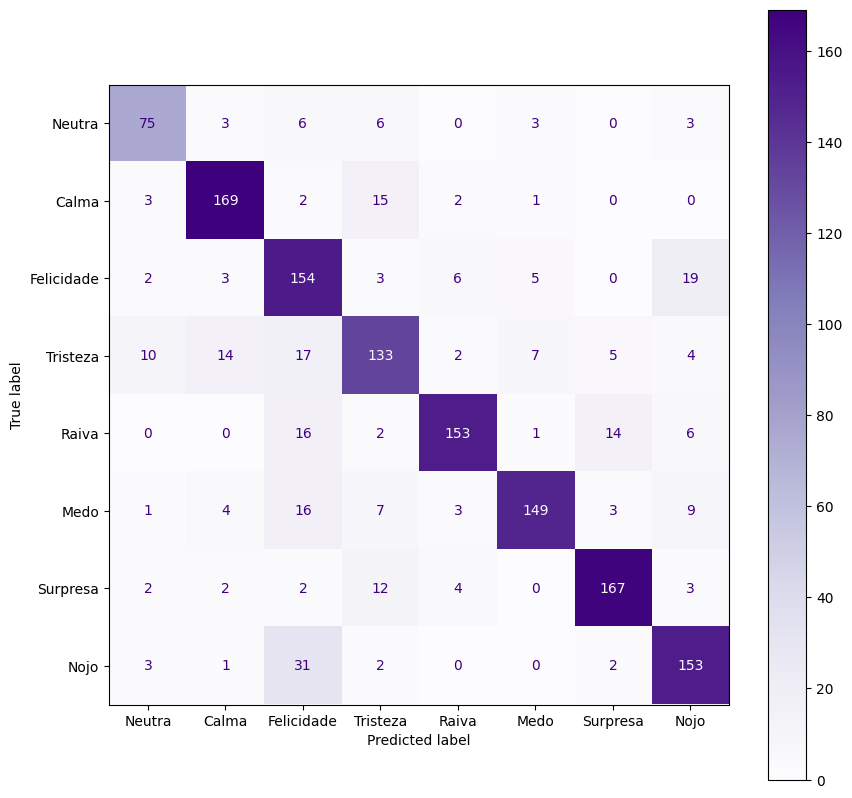

In [25]:
_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Purples', display_labels=my_classes, ax=ax)